In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

%matplotlib inline

In [4]:
df = pd.read_csv("Data_for_UCI_named.csv")
df.head(2)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [6]:
df.isnull().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df = df.drop("stab", axis = 1)
df.sample()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
638,1.123531,4.517113,9.470682,6.56915,3.658899,-1.114721,-1.227247,-1.316931,0.144656,0.894082,0.119993,0.395992,stable


In [9]:
df.stabf.value_counts(normalize = True)

unstable    0.638
stable      0.362
Name: stabf, dtype: float64

In [10]:
target = "stabf"
y = df[target]
y = y.replace({"unstable":1, "stable":0})
y

0       1
1       0
2       1
3       1
4       1
       ..
9995    1
9996    0
9997    0
9998    1
9999    1
Name: stabf, Length: 10000, dtype: int64

In [11]:
X = df.drop(target, axis = 1)
X.sample()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
7965,2.060037,8.40115,3.201655,9.747564,4.060921,-1.902467,-1.399467,-0.758988,0.423748,0.182964,0.178791,0.517955


In [12]:
# Scale the featured variables
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
scaled_X.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,-0.835374,-0.791317,1.141704,1.652103,0.017397,1.079405,-0.017078,-1.092545,0.457467,1.220013,1.321628,1.579026
1,1.478297,-0.126705,-0.803111,-1.415043,1.752124,-1.593619,-1.438158,-0.011575,-0.406791,1.230354,0.135424,0.936256
2,1.357093,1.312140,-0.803499,-1.471504,-0.458492,0.098253,-0.062840,0.760963,-1.319852,0.881299,1.146596,-1.513802
3,-1.653138,0.882289,-0.278354,-1.060901,0.284250,0.513904,-1.591046,0.583414,-0.287304,1.647250,1.474543,-0.591750
4,-0.771543,0.860108,-0.111670,1.680114,-0.298075,0.287450,-1.376343,1.606636,0.992226,-0.253610,0.481133,1.079063


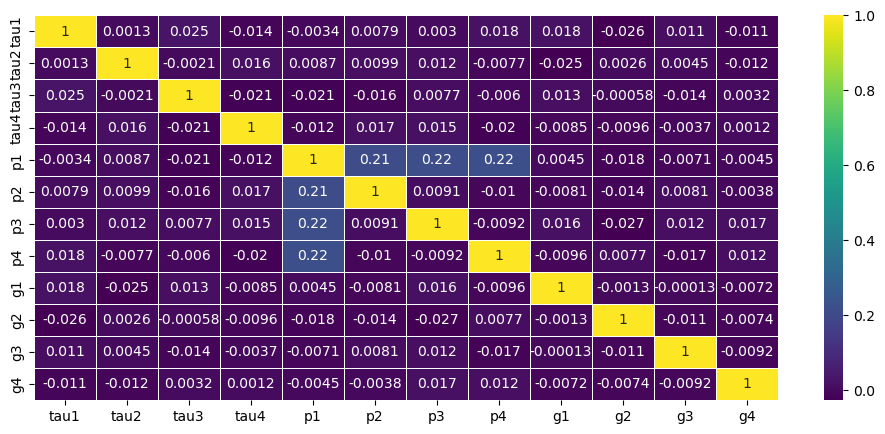

In [13]:
plt.figure(figsize=[12,5])
sns.heatmap(scaled_X.abs().corr(), annot=True, linewidths=0.5, cmap = "viridis");

In [14]:
scaled_X.describe().T

,count,mean,std,min,25%,50%,75%,max
tau1,10000.0,-1.919187e-16,1.00005,-1.731763,-0.866066,0.000001,0.865913,1.731859
tau2,10000.0,-3.972378e-17,1.00005,-1.732001,-0.865975,-0.000007,0.865987,1.731992
tau3,10000.0,-7.942536e-17,1.00005,-1.731766,-0.865837,-0.000009,0.866006,1.731850
tau4,10000.0,-2.283951e-16,1.00005,-1.731874,-0.866041,-0.000096,0.865966,1.731846
p1,10000.0,-3.023137e-16,1.00005,-2.881725,-0.706933,0.001363,0.707890,2.811268
p2,10000.0,-1.813716e-16,1.00005,-1.731796,-0.865796,0.000079,0.866078,1.731800
p3,10000.0,-1.297074e-16,1.00005,-1.731921,-0.866083,0.000059,0.865924,1.731880
p4,10000.0,-4.056755e-17,1.00005,-1.731879,-0.865931,-0.000017,0.865874,1.731991
g1,10000.0,1.723732e-16,1.00005,-1.732013,-0.865945,0.000034,0.865787,1.731819
g2,10000.0,1.033396e-16,1.00005,-1.731859,-0.865839,0.000011,0.865990,1.731848


In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (8000, 12)
X_test:  (2000, 12)
y_train:  (8000,)
y_test:  (2000,)


In [16]:
models = {
    "random-forest-classifier": RandomForestClassifier(random_state=1),
    "extra-trees-classifier": ExtraTreesClassifier(random_state=1),
    "XGB-classifier": XGBClassifier(random_state=1),
    "LGBM-classifier": LGBMClassifier(random_state=1)
}
models

{'random-forest-classifier': RandomForestClassifier(random_state=1),
 'extra-trees-classifier': ExtraTreesClassifier(random_state=1),
 'XGB-classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=1, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'LGBM-classifier': LGBMClassifier(random_state=1)}

C:\Users\damol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\damol\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:32:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


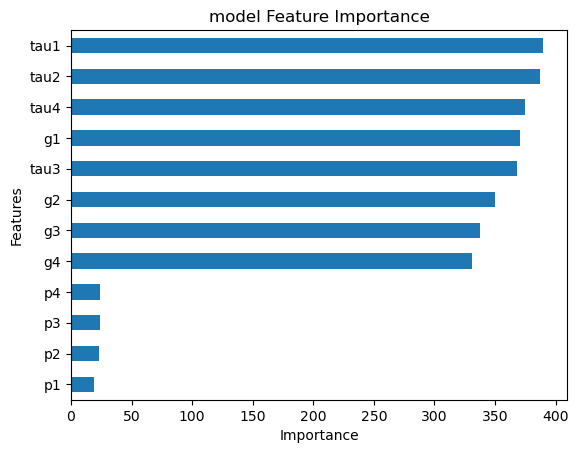

In [17]:
model_score = {}
for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Score model
    model_score[name] = model.score(X_test, y_test)
    
    importances = model.feature_importances_

    # Put importances into a Series
    feat_imp = pd.Series(importances, index = X_train.columns).sort_values(key=abs)

    # Plot series
    feat_imp.tail.plot(kind = "barh")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("model Feature Importance")
    
model_score = pd.Series(model_score)  
    

In [18]:
model_score

random-forest-classifier    0.9290
extra-trees-classifier      0.9280
XGB-classifier              0.9455
LGBM-classifier             0.9400
dtype: float64